# Tutorial. Distance between spike trains

**Importing necessary libs.**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

Importing SPIKE, VP, and SpikeShip measures

In [2]:
import sys
sys.path.append('/mnt/pns/home/sotomayorb/git/spyke-tools-dev/')

In [3]:
from spyketools.proc.distances.ISI.ISI_distance import isi_distance_python
from spyketools.proc.distances.SPIKE.SPIKE_distance import SPIKE_distance_cython
from spyketools.proc.distances.RISPIKE.RISPIKE_distance import spike_distance_rf
from spyketools.proc.distances.victor_purpura.victor_purpura_distance import victor_purpura_distance
from spikeship import spikeship

**`TODO:`** Move to SpikeShip src

In [4]:
# ADD IN SPIKESHIP SRC
def spikeship_single_neuron(st1, st2, return_global_shift=False):
    len_st1 = len(st1)
    len_st2 = len(st2)
    if len(st1) != len(st2):
        if len_st1 > len_st2:
            c_temp = spikeship.signature_emd_ss2(st1, st2)
            C = c_temp[0]
            W = c_temp[1] / (len_st1 * len_st2)
        else:
            c_temp = spikeship.signature_emd_ss2(st2, st1)
            C = -c_temp[0] 
            W =  c_temp[1] / (len_st1 * len_st2)
    else:
        c_temp = spikeship.signature_emd_ss2(st2, st1)
        C = c_temp[0]
        W = 1.0/c_temp[1]
        
    # computation of D
    if np.sum(W)==len(W): # single spike patterns
        g = np.median(C)
    else:
        if np.sum(W)>0:     # multi-spike patterns
            g = tools.weighted_median(x=C,w=W)
        else: # it ocurrs when two epochs do not have flow because one of the is spikeless
            g = np.nan #0.
    
    f = np.sum(np.abs((C-g)*W))
    
    if return_global_shift:
        return f, g
    else:
        return f

**`TODO:`** Move to main lib

In [5]:
from spikeship import spikeship, tools

In [6]:
#MOVE TO H:\git\spyke-tools-dev\spyketools\proc\distances\spike_metrics
def spike_train_distance(st1, st2, metric, attrs={}):
    metric = metric.lower()
    ret = None
    # attrs management
    # firing rate related
    if (not 'window_length' in attrs) or (attrs['window_length'] is None):
        window_length = np.max(np.concatenate([st1, st2]))
    else:
        window_length = attrs['window_length']
    # vp-related
    if (not 'cost' in attrs) or (attrs['cost'] is None):
        cost = (len(st1)+len(st2))/2.
    else:
        cost = attrs['cost']

    dist = None
    if metric == "firing_rates" or metric == 'firing_rates_z':
        dist = len(st1)-len(st2)

    elif metric == "spikeship":
            return_global_shift = ("return_global_shift" in attrs) and (attrs['return_global_shift'])
            dist = spikeship_single_neuron(st1, st2, return_global_shift=return_global_shift)
    else:
                  
        if metric == "victor_purpura":
            dist = victor_purpura_distance(st1, st2, cost)

        elif metric == "isi":
            dist = np.abs(isi_distance_python(st1, st2, t_start=0, t_end=window_length))

        elif metric == "spike":
            dist = np.abs(SPIKE_distance_cython(st1, st2, t_start=0, t_end=window_length)) #SPIKE_distance_pw(spike_times, ii_spike_times, epoch_index_pairs, window_length)

        elif metric == "ri-spike":
            dist = np.abs(spike_distance_rf(st1, st2, t_start=0, t_end=window_length)) #RISPIKE_distance_pw(spike_times, ii_spike_times, epoch_index_pairs, window_length)
        else:
            raise NotImplementedError("metric '%s' is not implemented." % metric)
    return dist

**Data simulation**

In this tutorial, we will generate three spike trains from random uniform distribution (NumPy's random module)

In [7]:
window_length    = 1
random_rate_st1  = 20
random_rate_st2  = 10
random_rate_st3  = 30

In [8]:
st1 = np.random.uniform(0, window_length, int(np.rint(window_length * random_rate_st1)))
st1

array([0.54520052, 0.05090904, 0.63161995, 0.40325893, 0.10522219,
       0.43758888, 0.9247742 , 0.28893735, 0.07625928, 0.30474875,
       0.002221  , 0.59727108, 0.25256447, 0.94319305, 0.6687706 ,
       0.03243689, 0.75669847, 0.92521665, 0.31816833, 0.22055844])

In [9]:
st2 = np.random.uniform(0, window_length, int(np.rint(window_length * random_rate_st2)))
st2

array([0.40965511, 0.3069141 , 0.04365799, 0.88525141, 0.32718722,
       0.84087039, 0.08741324, 0.52789228, 0.82462147, 0.37480393])

In [10]:
st3 = np.random.uniform(0, window_length, int(np.rint(window_length * random_rate_st3)))
st3

array([0.61477569, 0.4908755 , 0.69913879, 0.79592393, 0.73106154,
       0.01061136, 0.37456041, 0.1509597 , 0.78696273, 0.34206565,
       0.87216871, 0.77895042, 0.89375029, 0.87955936, 0.58840796,
       0.64753096, 0.27331953, 0.22555311, 0.34791837, 0.91308568,
       0.14778284, 0.88721528, 0.82287604, 0.59402447, 0.37987385,
       0.5182529 , 0.44262754, 0.99591286, 0.87712421, 0.04410692])

In [11]:
# visualization options:
ms = 15 # marker size

([<matplotlib.axis.YTick at 0x7fdd404b6e80>,
 <a list of 3 Text yticklabel objects>)

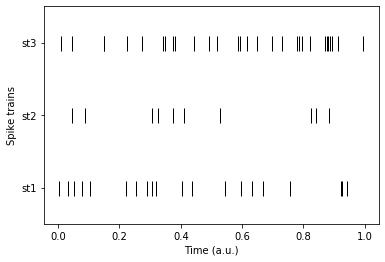

In [12]:
plt.plot(st1, np.ones(random_rate_st1)*0, color='k', ls='', marker='|', ms=ms)
plt.plot(st2, np.ones(random_rate_st2)*1, color='k', ls='', marker='|', ms=ms)
plt.plot(st3, np.ones(random_rate_st3)*2, color='k', ls='', marker='|', ms=ms)
plt.ylim([-0.5, 2.5])
plt.xlabel("Time (a.u.)")
plt.ylabel("Spike trains")
plt.yticks([0,1,2], ["st1", "st2", "st3"])

### Computation of spike train distances

**SpikeShip**

Extraction of global shift $G$ or alignment (optional)

In [13]:
spike_train_distance(st1, st3, metric='SpikeShip')

0.3730175305995934

In [14]:
f, G = spikeship_single_neuron(st1, st2, return_global_shift=True)
print ("Neuron-specific flow:", f)
print ("Global shift:", G)

Neuron-specific flow: 0.2699476620590623
Global shift: -0.022438472329331716


In [15]:
spike_train_distance(st1, st2, metric='SpikeShip')

0.2699476620590623

In [16]:
spike_train_distance(st1, st2, metric='SpikeShip', attrs={'return_global_shift' : True})

(0.2699476620590623, -0.022438472329331716)

In [17]:
spike_train_distance(st1, st2, metric='ISI', attrs={'window_length' : 1})

9.741799938542744

In [18]:
spike_train_distance(st1, st2, metric='SPIKE', attrs={'window_length' : 1})

571.313769105488

In [19]:
spike_train_distance(st1, st2, metric='RI-SPIKE', attrs={'window_length' : 1})

17.159171399618273

In [20]:
spike_train_distance(st1, st2, metric='victor_purpura', attrs={'cost' : 0})

10.0

In [21]:
spike_train_distance(st1, st2, metric='victor_purpura', attrs={'cost' : 1})

10.29507830802713

In [22]:
spike_train_distance(st1, st2, metric='victor_purpura')

14.42617462040693

In [23]:
spike_train_distance(st1, st2, metric='ISI', attrs={'window_length' : 1}), spike_train_distance(st2, st1, metric='ISI', attrs={'window_length' : 1})

(0.568530882002483, 0.568530882002483)

In [24]:
spike_train_distance(st1, st2, metric='SPIKE', attrs={'window_length' : 1}), spike_train_distance(st2, st1, metric='SPIKE', attrs={'window_length' : 1})

(0.3324823396088743, 0.3324823396088743)

### Comparison between three spike trains

([<matplotlib.axis.YTick at 0x7fdd3f6529b0>,
 <a list of 3 Text yticklabel objects>)

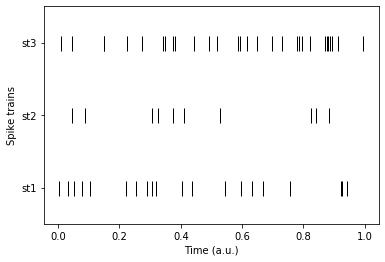

In [25]:
plt.plot(st1, np.ones(random_rate_st1)*0, color='k', ls='', marker='|', ms=ms)
plt.plot(st2, np.ones(random_rate_st2)*1, color='k', ls='', marker='|', ms=ms)
plt.plot(st3, np.ones(random_rate_st3)*2, color='k', ls='', marker='|', ms=ms)
plt.ylim([-0.5, 2.5])
plt.xlabel("Time (a.u.)")
plt.ylabel("Spike trains")
plt.yticks([0,1,2], ["st1", "st2", "st3"])

In [26]:
st3

array([0.61477569, 0.4908755 , 0.69913879, 0.79592393, 0.73106154,
       0.01061136, 0.37456041, 0.1509597 , 0.78696273, 0.34206565,
       0.87216871, 0.77895042, 0.89375029, 0.87955936, 0.58840796,
       0.64753096, 0.27331953, 0.22555311, 0.34791837, 0.91308568,
       0.14778284, 0.88721528, 0.82287604, 0.59402447, 0.37987385,
       0.5182529 , 0.44262754, 0.99591286, 0.87712421, 0.04410692])

In [27]:
spikeship_st12 = spike_train_distance(st1, st2, metric='SpikeShip')
spikeship_st13 = spike_train_distance(st1, st3, metric='SpikeShip')
spikeship_st23 = spike_train_distance(st2, st3, metric='SpikeShip')

In [28]:
shift_costs = [1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6]

In [29]:
VP_costs = [] # VP distances for different values of q
for q in shift_costs:
    temp_distance = spike_train_distance(st1, st2, metric='victor_purpura', attrs={'cost' : q})
    VP_costs.append(temp_distance)

Text(0, 0.5, 'distance')

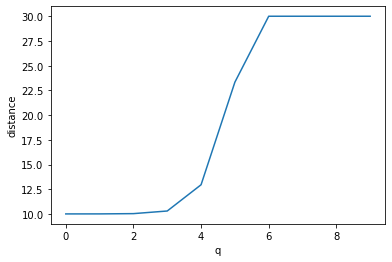

In [30]:
plt.plot(VP_costs)
plt.xlabel("q")
plt.ylabel("distance")

---